In [21]:
import os
import csv

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


# <u>Tentative de modelisation et prédiction de la variable : Intensité d'emission de GES</u>

## <u>1 : Modelisations en prenant en compte la note Energy Star (E*)</u>
### <u>1.1 : Regressions lineaires</u>

## <u>2 : Etude de l'importance de la note Energy Star</u>
### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>
### <u>2.2 : Utilisation de la certification plutot que le score</u>


## <u>1 : Modelisations prenant en compte toutes les variables retenues lors de l'étude</u>
### <u>1.1 : Regressions lineaires</u>

#### 1.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire (breakpoint = export 1)
    -  Note : Donnees inutilisables, oublie d'export de la variable cible
- Un split satisfaisant a deja été trouvé et fixé, ces données viendront sur-ecrire le split proposé par le modele
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out

In [2]:
# train_file, test_file = "./data/train_set_70percent_ghg.csv", "./data/test_set_30percent_ghg.csv"
general_file = "./data/seattle_predict_ghg_eui.csv"  # Used as backup


In [3]:
df_ghg = pd.read_csv(general_file)
df_ghg.set_index("OSEBuildingID", inplace=True)


In [4]:
df_ghg.head()


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_ptype_Mixed Use Property,ohe_ptype_Office,ohe_ptype_Other,ohe_ptype_Refrigerated Warehouse,ohe_ptype_Residence Hall,ohe_ptype_Small & Medium medical facility,ohe_ptype_Small & Mid-Sized Office,ohe_ptype_Supermarket & Grocery store,ohe_ptype_Warehouse,ohe_ptype_Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,1927,1,12,60.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.615322,1.799564,0.659821,0.913481,4.178122,1996,1,11,61.0,0.855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.380423,3.572830,-0.095878,1.536320,1.009034,1926,1,10,56.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.401384,1.074583,0.292078,0.455283,2.089235,1926,1,11,27.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.326328,3.945117,-0.029889,0.564008,2.706276,1928,1,9,48.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_ghg.columns


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_nbhood_BALLARD',
       'ohe_nbhood_CENTRAL', 'ohe_nbhood_DELRIDGE', 'ohe_nbhood_DOWNTOWN',
       'ohe_nbhood_EAST', 'ohe_nbhood_GREATER DUWAMISH',
       'ohe_nbhood_LAKE UNION', 'ohe_nbhood_MAGNOLIA / QUEEN ANNE',
       'ohe_nbhood_NORTH', 'ohe_nbhood_NORTHEAST', 'ohe_nbhood_NORTHWEST',
       'ohe_nbhood_SOUTHEAST', 'ohe_nbhood_SOUTHWEST', 'ohe_ptype_Hospital',
       'ohe_ptype_Hotel', 'ohe_ptype_K-12 School', 'ohe_ptype_Large Office',
       'ohe_ptype_Mixed Use Property', 'ohe_ptype_Office', 'ohe_ptype_Other',
       'ohe_ptype_Refrigerated Warehouse', 'ohe_ptype_Residence Hall',
    

In [6]:
# Target : target_GHGEmissionsIntensity(kgCO2e/ft2) :

droplist = [
    "scaled_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "target_SourceEUI(kWh/m2)",  # not to scale
    ]

df_model = df_ghg.drop(columns=droplist)


In [7]:
ghg_target = "target_GHGEmissionsIntensity(kgCO2e/ft2)"
ghg_regression = Linear_reg(dataframe=df_model, target=ghg_target)


#### Execution : 
Parametres : 
- Ridge = 0.1, 45, step 0.05
- Elastic Net = Alpha = Alpha_ridge = 0.1, 45, step 0.05, default L1 ratio
- Lasso Alpha = 0.01, 15, 0.04

In [8]:
ghg_regression.execute_all()


##### --> 1 Visualisation des alphas et leur pertinence, affichage des meilleurs hyperparametres
##### --> 2 Comparaison des metriques

In [9]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.1
Time used during fit = 7.4725787080824375
Time used during predict = 8.725002408027649e-05


Ridge: 

Ridge best Alpha : 14.450000000000005
Time used during fit = 0.10985412495210767
Time used during predict = 7.54999928176403e-05


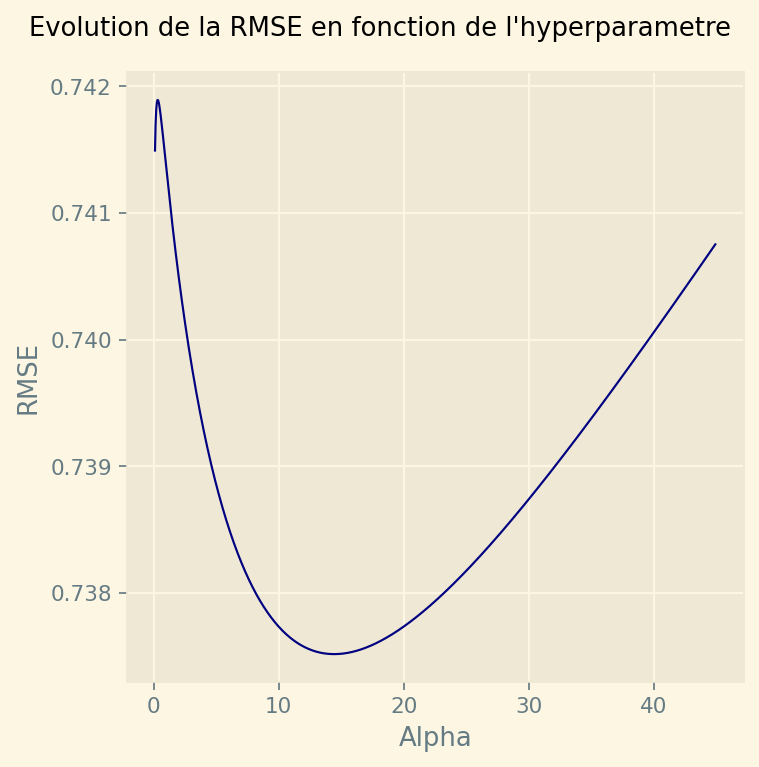

In [10]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")

ghg_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.14083649963140488
Time used during predict = 7.370812818408012e-05


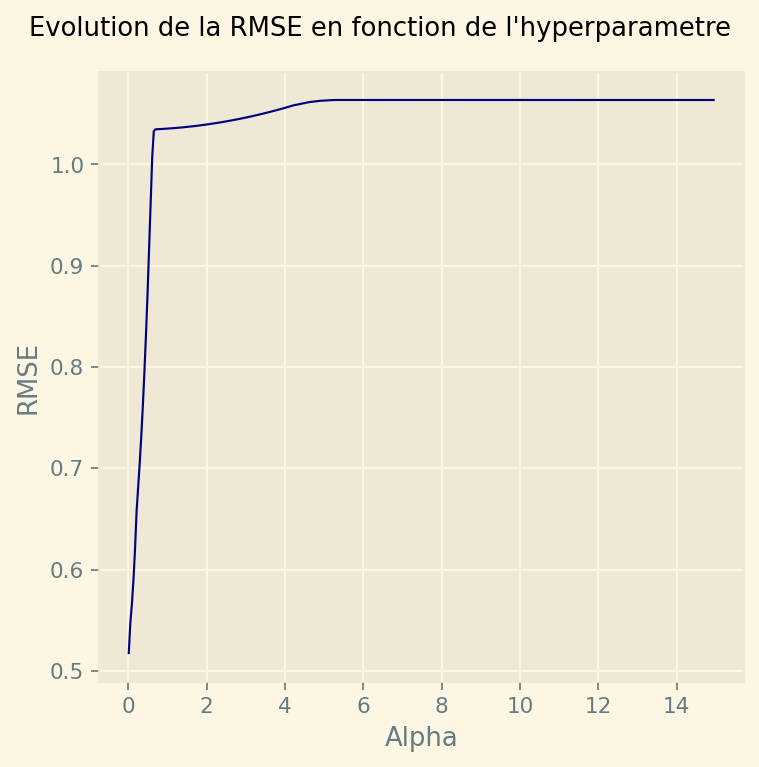

In [11]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")

ghg_regression.lasso_plot()


In [12]:
metrics_with_estar_l1out = ghg_regression.format_all_metrics()

df_predictions_estar_l1out = ghg_regression.df_predictions

metrics_with_estar_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.709625,0.513474,0.737517,0.607362,0.718708,0.591264,0.990386,0.574039
Test,0.616260,0.625913,0.614216,0.628390,0.623147,0.617505,0.627784,0.611792


In [91]:
# freeze_model(model=ghg_regression, save_file=True, file_path="./data/ghg_splits.csv")
# uncomment to save train test split ids (OSEBuildingID)


#### 1.1.b : Cross validation = RepeatedKfold
- Memes parametres que 1.1.a
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : RepeatedKfold(30 fois : 10 splits, 3 executions)
- On attend des temps de traitement nettement superieurs

In [14]:
k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ghg_regression.common_parameters["cv"] = k_folds


In [92]:
# Re executing all with adjusted cross validation parameters :

ghg_regression.execute_all()


ValueError: could not convert string to float: ''

In [ ]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


In [ ]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")


In [ ]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")


In [ ]:
metrics_with_estar_rkfold = ghg_regression.format_all_metrics()

df_predictions_estar_rkfold = ghg_regression.df_predictions

metrics_with_estar_rkfold


##### Parametres de Ridge :
On peut maintenant comparer les deux methodes de validation sur les memes données et memes algorithmes.
- Ridge affiche son meilleur alpha à 44.95000000000002, le pas de .05 l'aurait fait depasser la limite de 45 fixée au lancement
    - --> Sauvegarde de Ridge avec parametres actuels, on reexecute Ridge avec pour range (44, 90, .05)

In [ ]:
ridge_cv_kfold_first = ghg_regression.ridge_cv
ridge_table_kfold_first = ghg_regression.ridge_table


In [ ]:
new_range = np.arange(44, 90, .05)
ghg_regression.use_ridge_cv(alphas=new_range)


In [ ]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")


In [ ]:
# Reformating metrics with this ridge parameters : 
kfold_with_better_ridge = ghg_regression.format_all_metrics()

kfold_with_better_ridge


In [ ]:
metrics_with_estar_l1out


In [ ]:
print(f"Time to fit OLS : {ghg_regression.ols_time_card.t_fit}")
print(f"Time to predict OLS : {ghg_regression.ols_time_card.t_predict}")


##### Observations :
- NULL

In [ ]:
ghg_regression.scatter_true_pred("ols_regression")


NULL

In [ ]:
# Saving OLS :

ols_kfold = ghg_regression.lin_reg

# Reverting to cv = None for l1out

ghg_regression.common_parameters["cv"] = None


In [ ]:
original_range = np.arange(.1, 45, .05)
ghg_regression.use_ridge_cv(alphas=original_range)


In [ ]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")

ghg_regression.ridge_plot()


In [ ]:
ghg_regression.scatter_true_pred(regression_name="Ridge")


### NULL

## <u>2 : Etude de l'importance de la note Energy Star</u>
### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>

In [ ]:
drop_estar = ["ENERGYSTARScore"]
ghg_regression.drop_col(col_list=drop_estar)


In [ ]:
# checking ENERGYSTARScore not in matrices : shape should be 1 less than original dfs

if ghg_regression.X_test.shape[1] >= len(ghg_regression.df_train.columns) + 1:  # +1 because target still in cols
    print("Oops")
else:
    print("Ok")


#### 2.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire (breakpoint = export 1)
    -  Note : Donnees inutilisables, oublie d'export de la variable cible
- Un split satisfaisant a deja été trouvé et fixé, ces données viendront sur-ecrire le split proposé par le modele
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out
- Energy Star Score ne figure plus dans les matrices X_train, X_test
- Memes parametres initiaux que la regression comportant E*

#### Execution : 
Parametres : 
- Ridge = 0.1, 45, step 0.05
- Elastic Net = Alpha = Alpha_ridge = 0.1, 45, step 0.05, default L1 ratio
- Lasso Alpha = 0.01, 15, 0.04

In [ ]:
ghg_regression.execute_all()


In [ ]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


In [ ]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")

ghg_regression.ridge_plot()


In [ ]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")

ghg_regression.lasso_plot()


In [ ]:
metrics_without_estar_l1out = ghg_regression.format_all_metrics()

df_predictions_no_estar_l1out = ghg_regression.df_predictions

metrics_without_estar_l1out


#### 2.1.b : Cross validation = RepeatedKfold
- Memes parametres que 2.1.a
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : RepeatedKfold(30 fois : 10 splits, 3 executions)
- On attend des temps de traitement nettement superieurs

In [ ]:
ghg_regression.common_parameters["cv"] = k_folds


In [ ]:
ghg_regression.execute_all()


In [ ]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


In [ ]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")


In [ ]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")


##### NULL

In [ ]:
ridge_cv_kfold_no_estar = ghg_regression.ridge_cv
ridge_table_kfold_no_estar = ghg_regression.ridge_table


In [ ]:
new_range = np.arange(44, 90, .05)
ghg_regression.use_ridge_cv(alphas=new_range)


In [ ]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")


In [ ]:
# Compairing both tables :

ridge_table_kfold_no_estar

In [ ]:
ghg_regression.ridge_table

#### NULL

In [ ]:
metrics_without_estar_l1out

In [ ]:
ghg_regression.format_all_metrics()

In [ ]:
metrics_with_estar_l1out

In [ ]:
metrics_with_estar_rkfold

#### NULL